In [1]:
"""
Hopfield Network Implementation for Pattern Recognition
A fully-connected recurrent neural network that stores and recalls patterns.
"""
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [ ]:
# Configuration
N_SAMPLES = 3  # Number of training patterns (keep your current value)
IMAGE_SIZE = 24  # MNIST image dimensions after cropping (28 -> 24)

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Crop 1 pixel border on all sides (border is black in MNIST)
X_train = X_train[:, 2:-2, 2:-2]
X_test = X_test[:, 2:-2, 2:-2]

# Preprocess: normalize and binarize to {-1, +1}
X_train = X_train.astype('float32') / 255.0
image_means = X_train.mean(axis=(1, 2), keepdims=True)
X_train = np.where(X_train > image_means, 1, -1).astype(np.int8)

# Select subset for demonstration
training_patterns = X_train[:N_SAMPLES]

print(f"MNIST data shape (after crop): {X_train.shape}")
print(f"Using {N_SAMPLES} patterns for memory association")
print(f"Pattern dimension: {IMAGE_SIZE}×{IMAGE_SIZE} = {IMAGE_SIZE**2} neurons")

MNIST data shape (after crop): (60000, 24, 24)
Using 3 patterns for memory association
Pattern dimension: 24×24 = 576 neurons


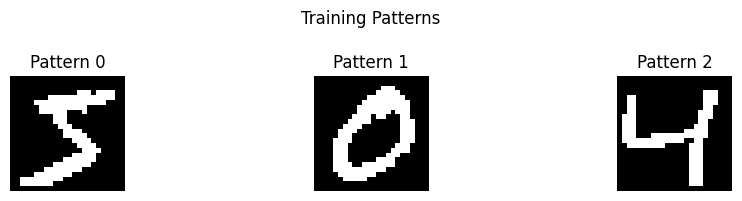

In [3]:
# Visualize training patterns
fig, axes = plt.subplots(1, N_SAMPLES, figsize=(10, 2))
axes = axes.flatten()

for i in range(N_SAMPLES):
    axes[i].imshow(training_patterns[i], cmap='gray', interpolation='nearest')
    axes[i].set_title(f"Pattern {i}")
    axes[i].axis('off')

plt.suptitle("Training Patterns")
plt.tight_layout()
plt.show()

In [4]:
class Neuron:
    """
    A single neuron in the Hopfield network.
    State is binary: +1 (active) or -1 (inactive).
    """
    def __init__(self, index, bias=0.0):
        self.index = index
        self.bias = bias
        self.state = np.random.choice([-1, 1])

    def update_state(self, input_sum, stochastic=False, temperature=1.0):
        """
        Update neuron state based on weighted input.
        
        Args:
            input_sum: Sum of weighted inputs plus bias
            stochastic: If True, use probabilistic update (Boltzmann); else deterministic (Hopfield)
            temperature: Controls randomness in stochastic mode
        """
        if not stochastic:
            # Hopfield: deterministic threshold
            self.state = 1 if input_sum >= 0 else -1
        else:
            # Boltzmann: probabilistic update
            prob = 1 / (1 + np.exp(-input_sum / temperature))
            self.state = 1 if np.random.rand() < prob else -1

In [5]:
class HopfieldNetwork:
    """
    Hopfield Network: A recurrent neural network that stores patterns in weights.
    
    The weight matrix is learned via Hebbian rule: W = (1/P) * Σ(p * p^T)
    This creates an energy landscape where training patterns are stable attractors.
    """
    def __init__(self, n_neurons):
        """
        Args:
            n_neurons: Number of neurons (equals pattern dimension)
        """
        self.neurons = [Neuron(i) for i in range(n_neurons)]
        self.W = np.zeros((n_neurons, n_neurons))

    def train(self, patterns):
        """
        Learn patterns using Hebbian learning rule.
        Sculpts the energy landscape so training patterns become stable states.
        
        Args:
            patterns: Array of shape (n_patterns, n_neurons) in {-1, +1}
        """
        patterns = np.array(patterns)

        # Subtract mean pattern (zero-mean features)
        mean_pattern = patterns.mean(axis=0, keepdims=True)
        centered = patterns - mean_pattern

        self.W[:] = 0.0
        for p in patterns:
            p = p.reshape(-1, 1)
            self.W += p @ p.T

        np.fill_diagonal(self.W, 0)
        # Optional normalization (theory uses 1/N)
        self.W /= centered.shape[1]  # divide by number of neurons

    def set_state(self, state_vector):
        """
        Set network state to a specific pattern.
        
        Args:
            state_vector: 1D array of neuron states in {-1, +1}
        """
        state_vector = state_vector.flatten()
        for i, val in enumerate(state_vector):
            self.neurons[i].state = int(val)

    def corrupt_pattern(self, pattern, corruption_proportion):
        """
        Randomly flip a proportion of neurons in a pattern.
        
        Args:
            pattern: 1D or 2D pattern array in {-1, +1}
            corruption_proportion: Float in [0, 1] indicating fraction of neurons to flip
            
        Returns:
            Corrupted pattern with same shape as input
        """
        corrupted = pattern.copy().flatten()
        n_flip = int(len(corrupted) * corruption_proportion)
        flip_indices = np.random.choice(len(corrupted), size=n_flip, replace=False)
        corrupted[flip_indices] *= -1  # Flip selected neurons
        
        return corrupted.reshape(pattern.shape)

    def compute_energy(self):
        """
        Compute network energy: E = -0.5 * s^T * W * s
        Lower energy = more stable state
        """
        s = np.array([n.state for n in self.neurons])
        return -0.5 * s @ self.W @ s

    def update(self, steps=100, track_energy=False):
        """
        Asynchronous update: randomly select neurons and update their states.
        Network evolves toward lower energy states (attractors).
        
        Args:
            steps: Number of update iterations
            track_energy: If True, return list of energy values
            
        Returns:
            Energy history if track_energy=True, else None
        """
        n = len(self.neurons)
        energy_history = [] if track_energy else None
        
        for _ in range(steps):
            i = np.random.randint(n)
            self._update_neuron(i)
            
            if track_energy:
                energy_history.append(self.compute_energy())
        
        return energy_history

    def _update_neuron(self, i):
        """Update a single neuron based on its inputs."""
        neuron = self.neurons[i]
        # Compute weighted input sum from all other neurons
        input_sum = np.dot(self.W[i], [n.state for n in self.neurons]) + neuron.bias
        neuron.update_state(input_sum)

    def get_state(self):
        """Return current network state as array."""
        return np.array([n.state for n in self.neurons])

In [6]:
# Initialize and train network
n_neurons = IMAGE_SIZE * IMAGE_SIZE
net = HopfieldNetwork(n_neurons)

# Flatten patterns and train (use selected subset, not entire X_train!)
flat_patterns = training_patterns.reshape(N_SAMPLES, -1)
net.train(flat_patterns)

print(f"Network trained on {N_SAMPLES} patterns")
print(f"Weight matrix shape: {net.W.shape}")
print(f"Weight matrix range: [{net.W.min():.3f}, {net.W.max():.3f}]")

Network trained on 3 patterns
Weight matrix shape: (576, 576)
Weight matrix range: [-0.005, 0.005]


In [7]:
# Configuration for recall test
PATTERN_INDEX = 1  # Which training pattern to corrupt
CORRUPTION_PROPORTION = 0.15  # Proportion of neurons to randomly flip (10%)
UPDATE_STEPS = 10000  # Convergence iterations

# Create corrupted input
pattern_to_corrupt = training_patterns[PATTERN_INDEX]
corrupt_input = net.corrupt_pattern(pattern_to_corrupt, CORRUPTION_PROPORTION)

n_flipped = int(IMAGE_SIZE * IMAGE_SIZE * CORRUPTION_PROPORTION)
print(f"Corrupted pattern {PATTERN_INDEX}: flipped {n_flipped} neurons ({CORRUPTION_PROPORTION*100:.0f}%)")

Corrupted pattern 1: flipped 86 neurons (15%)


In [8]:
# Initialize network state with corrupted pattern
corrupt_input_flat = corrupt_input.flatten()
net.set_state(corrupt_input_flat)

initial_energy = net.compute_energy()
print(f"Initial energy: {initial_energy:.2f}")

# Run network to convergence and track energy
energy_history = net.update(steps=UPDATE_STEPS, track_energy=True)

final_energy = net.compute_energy()
print(f"\nFinal energy: {final_energy:.2f}")
print(f"Energy decreased by: {initial_energy - final_energy:.2f}")

Initial energy: -201.46

Final energy: -398.50
Energy decreased by: 197.04

Final energy: -398.50
Energy decreased by: 197.04


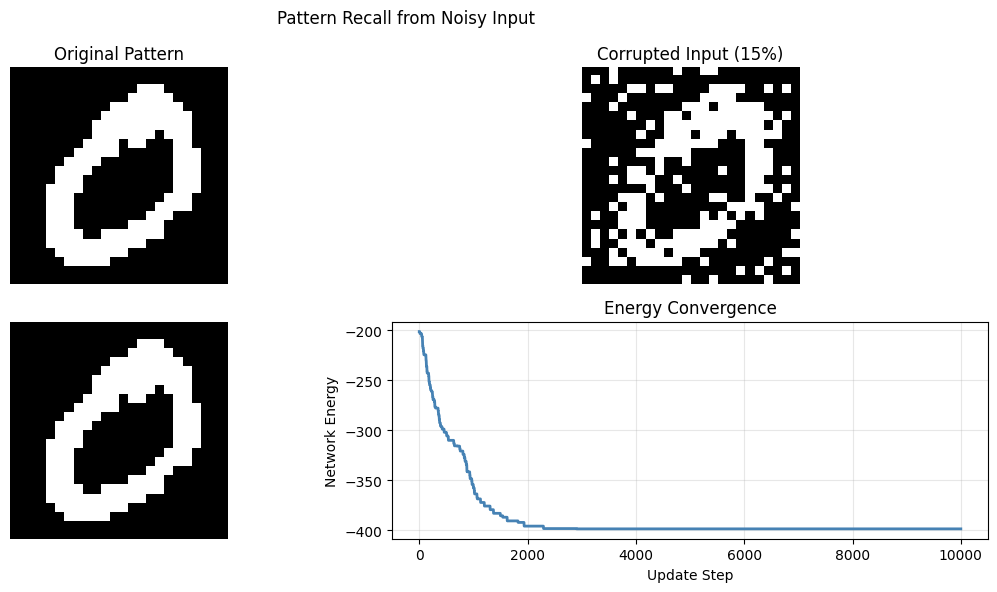

In [9]:
# Visualize input corruption and network recovery
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Original pattern
axes[0, 0].imshow(training_patterns[PATTERN_INDEX], cmap='gray')
axes[0, 0].set_title("Original Pattern")
axes[0, 0].axis('off')

# Corrupted input
axes[0, 1].imshow(corrupt_input, cmap='gray')
axes[0, 1].set_title(f"Corrupted Input ({CORRUPTION_PROPORTION*100:.0f}%)")
axes[0, 1].axis('off')

# Network's recovered pattern
recovered = net.get_state().reshape((IMAGE_SIZE, IMAGE_SIZE))
axes[1, 0].imshow(recovered, cmap='gray')
axes[1, 0].axis('off')

# Energy convergence
axes[1, 1].plot(energy_history, linewidth=2, color='steelblue')
axes[1, 1].set_xlabel("Update Step")
axes[1, 1].set_ylabel("Network Energy")
axes[1, 1].set_title("Energy Convergence")
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("Pattern Recall from Noisy Input")
plt.tight_layout()
plt.show()